In [71]:
# Importing libraries:
import torch
import torchvision
from torch import nn
from tqdm import tqdm
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torchvision.transforms import ToTensor
from torch.optim.lr_scheduler import OneCycleLR
from torchsummary import summary

In [2]:
# Defining transforms for training and testing data:
transform = transforms.Compose(
		[transforms.RandomCrop(32, padding=4),
		 transforms.RandomHorizontalFlip(),
		 transforms.ToTensor(),
		 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
# Downloading training and testing data:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# Initializing batch size:
batch=64

In [5]:
# Creating training and testing dataloaders:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch, shuffle=False, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [6]:
# Getting class names from the dataset:
classes = trainset.class_to_idx

In [7]:
# Defining basic block:
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1,dropout =0.2):
        super(BasicBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)    
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout(p = dropout)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = self.dropout(F.relu(self.bn1(self.conv1(x))))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



In [8]:
# Defining Resnet architecture:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10,dropout =0.2):
        super(ResNet, self).__init__()
        self.in_planes = 32

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3,stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.linear = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(p = dropout)
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.dropout(F.relu(self.bn1(self.conv1(x)))) 
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [9]:
train_losses = []
train_acc = []
test_losses_l1 = []
test_acc_l1 = []

In [11]:
# Function train:
def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar=tqdm(train_loader)
  correct = 0
  processed = 0
  criterion= nn.CrossEntropyLoss().to(device)
  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    y_pred = model(data)
    loss  = criterion(y_pred, target)
    train_losses.append(loss)
    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)
    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
  train_acc.append(100*correct/processed)

In [12]:
# Function test:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    criterion= nn.CrossEntropyLoss().to(device)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_losses_l1.append(test_loss)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc_l1.append(100. * correct / len(test_loader.dataset))

In [13]:
# Geting cpu or gpu device for training:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [14]:
#added code
def ResNet18():
    return ResNet(BasicBlock, [2,3,2,2])

In [15]:
# Loading model:
model=ResNet18().to(device)

In [16]:
# Displaying number of trainable parameters:
sum(p.numel() for p in model.parameters() if p.requires_grad)

2871594

In [ ]:
# Displaying summary of the model:
summary(model, input_size=(3,32,32))

In [18]:
# Initializing batch size Learning Rate annd moment:
epochs =50
LR = 0.01
moment = 0.9

In [19]:
# Training the model over training and testing datasets:

# optimizer = optim.RMSprop(model.parameters(), lr=LR, momentum =moment)
# optimizer = optim.Adam(model.parameters(),lr= LR,betas=(0.9, 0.999),eps=1e-08,weight_decay=0,amsgrad=False)

optimizer = optim.SGD(model.parameters(), lr=LR, momentum=moment)
scheduler = OneCycleLR(optimizer,max_lr=0.1,total_steps=epochs)

for epoch in range(epochs):
    print(f'Epoch: {epoch} Learning_Rate {scheduler.get_lr()}')
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:1565: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Epoch: 0 Learning_Rate [0.0040000000000000036]


  0%|          | 0/782 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=1.5490831136703491 Batch_id=781 Accuracy=40.75: 100%|██████████| 782/782 [01:31<00:00,  8.57it/s]



Test set: Average loss: 0.0206, Accuracy: 5324/10000 (53.2400%)

Epoch: 1 Learning_Rate [0.0052034602152724735]


Loss=0.9059499502182007 Batch_id=781 Accuracy=58.10: 100%|██████████| 782/782 [01:27<00:00,  8.90it/s]



Test set: Average loss: 0.0169, Accuracy: 6143/10000 (61.4300%)

Epoch: 2 Learning_Rate [0.008753494340683884]


Loss=0.9847870469093323 Batch_id=781 Accuracy=65.12: 100%|██████████| 782/782 [01:27<00:00,  8.92it/s]



Test set: Average loss: 0.0140, Accuracy: 6936/10000 (69.3600%)

Epoch: 3 Learning_Rate [0.014472088841534572]


Loss=0.497081458568573 Batch_id=781 Accuracy=69.59: 100%|██████████| 782/782 [01:30<00:00,  8.65it/s]



Test set: Average loss: 0.0135, Accuracy: 7115/10000 (71.1500%)

Epoch: 4 Learning_Rate [0.022072489510780793]


Loss=0.63237065076828 Batch_id=781 Accuracy=73.29: 100%|██████████| 782/782 [01:29<00:00,  8.69it/s]



Test set: Average loss: 0.0105, Accuracy: 7739/10000 (77.3900%)

Epoch: 5 Learning_Rate [0.03117358052235722]


Loss=0.6942166090011597 Batch_id=781 Accuracy=75.62: 100%|██████████| 782/782 [01:27<00:00,  8.91it/s]



Test set: Average loss: 0.0110, Accuracy: 7663/10000 (76.6300%)

Epoch: 6 Learning_Rate [0.04131899517009691]


Loss=0.7230163812637329 Batch_id=781 Accuracy=78.13: 100%|██████████| 782/782 [01:26<00:00,  9.00it/s]



Test set: Average loss: 0.0112, Accuracy: 7581/10000 (75.8100%)

Epoch: 7 Learning_Rate [0.052000000000000005]


Loss=0.9167162775993347 Batch_id=781 Accuracy=79.76: 100%|██████████| 782/782 [01:29<00:00,  8.69it/s]



Test set: Average loss: 0.0094, Accuracy: 8021/10000 (80.2100%)

Epoch: 8 Learning_Rate [0.0626810048299031]


Loss=1.0742080211639404 Batch_id=781 Accuracy=81.37: 100%|██████████| 782/782 [01:29<00:00,  8.71it/s]



Test set: Average loss: 0.0089, Accuracy: 8122/10000 (81.2200%)

Epoch: 9 Learning_Rate [0.07282641947764279]


Loss=0.7692888379096985 Batch_id=781 Accuracy=82.20: 100%|██████████| 782/782 [01:27<00:00,  8.93it/s]



Test set: Average loss: 0.0080, Accuracy: 8256/10000 (82.5600%)

Epoch: 10 Learning_Rate [0.08192751048921922]


Loss=0.30799269676208496 Batch_id=781 Accuracy=83.66: 100%|██████████| 782/782 [01:27<00:00,  8.97it/s]



Test set: Average loss: 0.0077, Accuracy: 8338/10000 (83.3800%)

Epoch: 11 Learning_Rate [0.08952791115846544]


Loss=0.24060775339603424 Batch_id=781 Accuracy=84.41: 100%|██████████| 782/782 [01:29<00:00,  8.69it/s]



Test set: Average loss: 0.0075, Accuracy: 8423/10000 (84.2300%)

Epoch: 12 Learning_Rate [0.09524650565931612]


Loss=0.35450276732444763 Batch_id=781 Accuracy=85.25: 100%|██████████| 782/782 [01:29<00:00,  8.73it/s]



Test set: Average loss: 0.0067, Accuracy: 8544/10000 (85.4400%)

Epoch: 13 Learning_Rate [0.09879653978472754]


Loss=0.22541287541389465 Batch_id=781 Accuracy=85.84: 100%|██████████| 782/782 [01:27<00:00,  8.89it/s]



Test set: Average loss: 0.0068, Accuracy: 8501/10000 (85.0100%)

Epoch: 14 Learning_Rate [0.1]


Loss=0.23445191979408264 Batch_id=781 Accuracy=86.81: 100%|██████████| 782/782 [01:27<00:00,  8.96it/s]



Test set: Average loss: 0.0067, Accuracy: 8531/10000 (85.3100%)

Epoch: 15 Learning_Rate [0.09979871550490317]


Loss=0.984356701374054 Batch_id=781 Accuracy=87.58: 100%|██████████| 782/782 [01:30<00:00,  8.63it/s]



Test set: Average loss: 0.0069, Accuracy: 8504/10000 (85.0400%)

Epoch: 16 Learning_Rate [0.09919648264401378]


Loss=0.4309903383255005 Batch_id=781 Accuracy=87.88: 100%|██████████| 782/782 [01:30<00:00,  8.69it/s]



Test set: Average loss: 0.0063, Accuracy: 8634/10000 (86.3400%)

Epoch: 17 Learning_Rate [0.09819815024222053]


Loss=0.4279133081436157 Batch_id=781 Accuracy=88.34: 100%|██████████| 782/782 [01:27<00:00,  8.90it/s]



Test set: Average loss: 0.0064, Accuracy: 8616/10000 (86.1600%)

Epoch: 18 Learning_Rate [0.09681175628501273]


Loss=0.1071649119257927 Batch_id=781 Accuracy=88.58: 100%|██████████| 782/782 [01:27<00:00,  8.94it/s]



Test set: Average loss: 0.0060, Accuracy: 8735/10000 (87.3500%)

Epoch: 19 Learning_Rate [0.09504846320134738]


Loss=0.31654050946235657 Batch_id=781 Accuracy=89.26: 100%|██████████| 782/782 [01:30<00:00,  8.66it/s]



Test set: Average loss: 0.0064, Accuracy: 8654/10000 (86.5400%)

Epoch: 20 Learning_Rate [0.09292246799033459]


Loss=0.17142492532730103 Batch_id=781 Accuracy=89.40: 100%|██████████| 782/782 [01:29<00:00,  8.70it/s]



Test set: Average loss: 0.0057, Accuracy: 8760/10000 (87.6000%)

Epoch: 21 Learning_Rate [0.0904508879153485]


Loss=0.43119457364082336 Batch_id=781 Accuracy=89.99: 100%|██████████| 782/782 [01:28<00:00,  8.87it/s]



Test set: Average loss: 0.0060, Accuracy: 8748/10000 (87.4800%)

Epoch: 22 Learning_Rate [0.08765362268588736]


Loss=0.20602819323539734 Batch_id=781 Accuracy=90.38: 100%|██████████| 782/782 [01:27<00:00,  8.91it/s]



Test set: Average loss: 0.0054, Accuracy: 8863/10000 (88.6300%)

Epoch: 23 Learning_Rate [0.08455319423681344]


Loss=0.08266354352235794 Batch_id=781 Accuracy=90.75: 100%|██████████| 782/782 [01:33<00:00,  8.35it/s]



Test set: Average loss: 0.0054, Accuracy: 8854/10000 (88.5400%)

Epoch: 24 Learning_Rate [0.0811745653949763]


Loss=0.04493343457579613 Batch_id=781 Accuracy=91.02: 100%|██████████| 782/782 [01:38<00:00,  7.94it/s]



Test set: Average loss: 0.0055, Accuracy: 8858/10000 (88.5800%)

Epoch: 25 Learning_Rate [0.07754493889320883]


Loss=0.28516247868537903 Batch_id=781 Accuracy=91.16: 100%|██████████| 782/782 [01:28<00:00,  8.80it/s]



Test set: Average loss: 0.0057, Accuracy: 8823/10000 (88.2300%)

Epoch: 26 Learning_Rate [0.07369353834991745]


Loss=0.16431140899658203 Batch_id=781 Accuracy=91.63: 100%|██████████| 782/782 [01:28<00:00,  8.79it/s]



Test set: Average loss: 0.0052, Accuracy: 8897/10000 (88.9700%)

Epoch: 27 Learning_Rate [0.06965137297768985]


Loss=0.19649691879749298 Batch_id=781 Accuracy=91.97: 100%|██████████| 782/782 [01:32<00:00,  8.45it/s]



Test set: Average loss: 0.0051, Accuracy: 8937/10000 (89.3700%)

Epoch: 28 Learning_Rate [0.0654509879153485]


Loss=0.21287645399570465 Batch_id=781 Accuracy=92.26: 100%|██████████| 782/782 [01:32<00:00,  8.46it/s]



Test set: Average loss: 0.0051, Accuracy: 8891/10000 (88.9100%)

Epoch: 29 Learning_Rate [0.06112620219362893]


Loss=0.46067014336586 Batch_id=781 Accuracy=92.63: 100%|██████████| 782/782 [01:29<00:00,  8.75it/s]



Test set: Average loss: 0.0047, Accuracy: 9011/10000 (90.1100%)

Epoch: 30 Learning_Rate [0.05671183644422961]


Loss=0.3361246585845947 Batch_id=781 Accuracy=92.81: 100%|██████████| 782/782 [01:28<00:00,  8.83it/s]



Test set: Average loss: 0.0049, Accuracy: 8993/10000 (89.9300%)

Epoch: 31 Learning_Rate [0.05224343254455968]


Loss=0.22963283956050873 Batch_id=781 Accuracy=93.05: 100%|██████████| 782/782 [01:32<00:00,  8.46it/s]



Test set: Average loss: 0.0047, Accuracy: 9039/10000 (90.3900%)

Epoch: 32 Learning_Rate [0.04775696745544034]


Loss=0.1278112381696701 Batch_id=781 Accuracy=93.36: 100%|██████████| 782/782 [01:32<00:00,  8.45it/s]



Test set: Average loss: 0.0050, Accuracy: 9000/10000 (90.0000%)

Epoch: 33 Learning_Rate [0.043288563555770404]


Loss=0.012314653024077415 Batch_id=781 Accuracy=93.94: 100%|██████████| 782/782 [01:29<00:00,  8.75it/s]



Test set: Average loss: 0.0048, Accuracy: 9015/10000 (90.1500%)

Epoch: 34 Learning_Rate [0.03887419780637107]


Loss=0.455530047416687 Batch_id=781 Accuracy=94.07: 100%|██████████| 782/782 [01:28<00:00,  8.82it/s]



Test set: Average loss: 0.0050, Accuracy: 8988/10000 (89.8800%)

Epoch: 35 Learning_Rate [0.03454941208465151]


Loss=0.20314520597457886 Batch_id=781 Accuracy=94.28: 100%|██████████| 782/782 [01:32<00:00,  8.43it/s]



Test set: Average loss: 0.0050, Accuracy: 9029/10000 (90.2900%)

Epoch: 36 Learning_Rate [0.030349027022310158]


Loss=0.393646240234375 Batch_id=781 Accuracy=94.54: 100%|██████████| 782/782 [01:32<00:00,  8.45it/s]



Test set: Average loss: 0.0048, Accuracy: 9040/10000 (90.4000%)

Epoch: 37 Learning_Rate [0.026306861650082565]


Loss=0.011328030377626419 Batch_id=781 Accuracy=94.78: 100%|██████████| 782/782 [01:29<00:00,  8.72it/s]



Test set: Average loss: 0.0048, Accuracy: 9021/10000 (90.2100%)

Epoch: 38 Learning_Rate [0.022455461106791173]


Loss=0.05032763257622719 Batch_id=781 Accuracy=95.28: 100%|██████████| 782/782 [01:28<00:00,  8.82it/s]



Test set: Average loss: 0.0049, Accuracy: 9085/10000 (90.8500%)

Epoch: 39 Learning_Rate [0.0188258346050237]


Loss=0.1482040286064148 Batch_id=781 Accuracy=95.71: 100%|██████████| 782/782 [01:32<00:00,  8.42it/s]



Test set: Average loss: 0.0046, Accuracy: 9100/10000 (91.0000%)

Epoch: 40 Learning_Rate [0.015447205763186566]


Loss=0.012538241222500801 Batch_id=781 Accuracy=95.96: 100%|██████████| 782/782 [01:32<00:00,  8.44it/s]



Test set: Average loss: 0.0046, Accuracy: 9133/10000 (91.3300%)

Epoch: 41 Learning_Rate [0.012346777314112658]


Loss=0.06863444298505783 Batch_id=781 Accuracy=96.28: 100%|██████████| 782/782 [01:29<00:00,  8.70it/s]



Test set: Average loss: 0.0047, Accuracy: 9094/10000 (90.9400%)

Epoch: 42 Learning_Rate [0.009549512084651508]


Loss=0.08456186950206757 Batch_id=781 Accuracy=96.44: 100%|██████████| 782/782 [01:28<00:00,  8.81it/s]



Test set: Average loss: 0.0046, Accuracy: 9161/10000 (91.6100%)

Epoch: 43 Learning_Rate [0.007077932009665416]


Loss=0.005889690946787596 Batch_id=781 Accuracy=96.51: 100%|██████████| 782/782 [01:32<00:00,  8.44it/s]



Test set: Average loss: 0.0046, Accuracy: 9143/10000 (91.4300%)

Epoch: 44 Learning_Rate [0.004951936798652629]


Loss=0.0427221953868866 Batch_id=781 Accuracy=96.84: 100%|██████████| 782/782 [01:32<00:00,  8.44it/s]



Test set: Average loss: 0.0046, Accuracy: 9158/10000 (91.5800%)

Epoch: 45 Learning_Rate [0.003188643714987268]


Loss=0.07632675021886826 Batch_id=781 Accuracy=96.91: 100%|██████████| 782/782 [01:29<00:00,  8.74it/s]



Test set: Average loss: 0.0045, Accuracy: 9168/10000 (91.6800%)

Epoch: 46 Learning_Rate [0.0018022497577794773]


Loss=0.3694065511226654 Batch_id=781 Accuracy=97.13: 100%|██████████| 782/782 [01:28<00:00,  8.83it/s]



Test set: Average loss: 0.0044, Accuracy: 9205/10000 (92.0500%)

Epoch: 47 Learning_Rate [0.0008039173559862364]


Loss=0.18033793568611145 Batch_id=781 Accuracy=97.32: 100%|██████████| 782/782 [01:32<00:00,  8.43it/s]



Test set: Average loss: 0.0046, Accuracy: 9171/10000 (91.7100%)

Epoch: 48 Learning_Rate [0.00020168449509684564]


Loss=0.13760793209075928 Batch_id=781 Accuracy=97.34: 100%|██████████| 782/782 [01:32<00:00,  8.44it/s]



Test set: Average loss: 0.0045, Accuracy: 9198/10000 (91.9800%)

Epoch: 49 Learning_Rate [4e-07]


Loss=0.09163559228181839 Batch_id=781 Accuracy=97.35: 100%|██████████| 782/782 [01:29<00:00,  8.72it/s]



Test set: Average loss: 0.0044, Accuracy: 9180/10000 (91.8000%)



In [33]:
#converting from cuda tensors to .cpu()
train_losses=torch.Tensor(train_losses).cpu()
arr_train=np.array(train_losses)

test_losses_l1=torch.Tensor(test_losses_l1).cpu()
arr_test=np.array(test_losses_l1)

train_acc=torch.Tensor(train_acc).cpu()
arr_train_acc=np.array(train_acc)

test_acc_l1=torch.Tensor(test_acc_l1).cpu()
arr_test_acc=np.array(test_acc_l1)

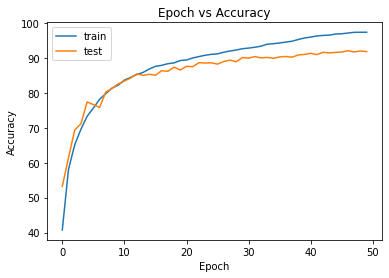

In [97]:
#plotting the accuracy
plt.plot(arr_train_acc)
plt.plot(arr_test_acc)
plt.legend(["train","test"])
plt.title("Epoch vs Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

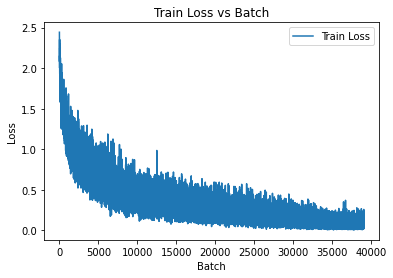

In [101]:
# Printing train loss:
plt.plot(arr_train )
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend(['Train Loss'])
plt.title('Train Loss vs Batch')
plt.show()

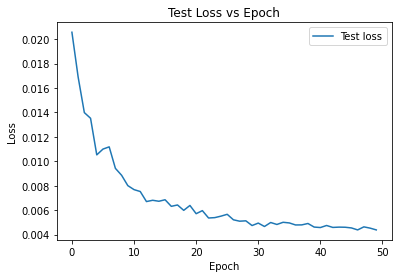

In [100]:
# Printing test loss:
plt.plot(arr_test)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Test loss'])
plt.title('Test Loss vs Epoch')
plt.show()

In [93]:
# Save random initial weights:
torch.save(model.state_dict(), 'miniProject1.pt')

In [94]:
# Sanity check:
test_model = ResNet(BasicBlock, [2,3,2,2])

In [95]:
# Key matching:
test_model.load_state_dict(torch.load('miniProject1.pt'))

<All keys matched successfully>

In [75]:
# Place model on GPU
test_model.to(device)

ResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): B

In [76]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): B